In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Set some default plotting parameters

plt.rcParams['font.size'] = 15
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 13

In [2]:
# Step 1: Simulator for the Galton Board

def galton_simulator(alpha, s, num_rows=31, num_beads=1000):
    """
    Simulates the Galton board experiment for given \u03b1 (inertia) and s (slope).
    
    Args:
        alpha (float): Inertia parameter.
        s (float): Slope parameter.
        num_rows (int): Number of rows in the Galton board.
        num_beads (int): Number of beads to simulate.

    Returns:
        np.ndarray: Distribution of beads in the bottom cells (32,).
    """
    positions = np.zeros(num_beads, dtype=int)
    for bead in range(num_beads):
        M = 0  # No bias at the first peg
        num_right = 0

        for _ in range(num_rows):
            prob_plus = 0.5 + (alpha * M + s)

            # Randomly choose between 0 and 1 based on the probabilities
            choice = 1 if np.random.rand() < prob_plus else 0

            if choice == 1:
                M = 0.5
                num_right += 1
            else:
                M = -0.5
        positions[bead] = num_right
    return positions 

def reshape_bin_array(data):
    unique_positions, counts = np.unique(data, return_counts=True)
    final_observed_data = np.zeros(32, dtype=int)
    # Map the counts to their corresponding bins
    for pos, count in zip(unique_positions, counts):
        final_observed_data[pos] = count    
    return final_observed_data


<bound method FigureBase.suptitle of <Figure size 1000x1000 with 3 Axes>>

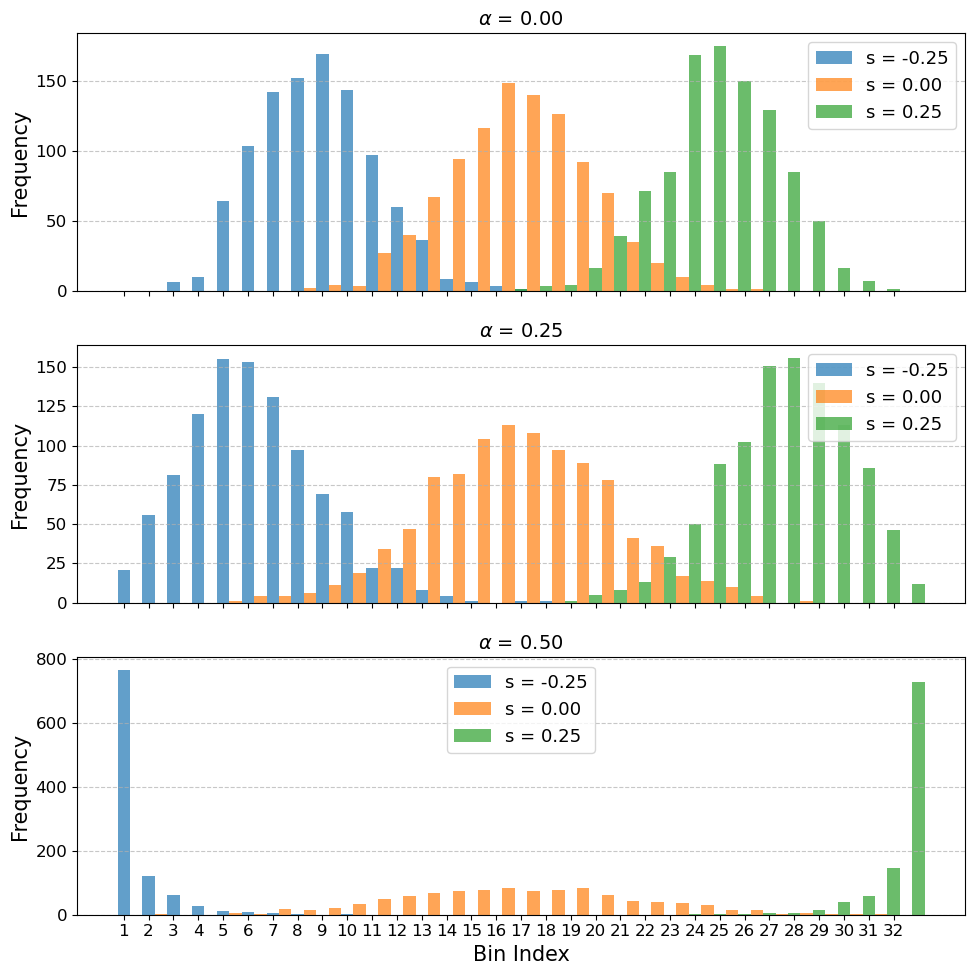

In [3]:
alphas = np.linspace(0, 0.5, 3)
ss = np.linspace(-0.25, 0.25, 3)

# Create subplots for all alpha values

fig, axes = plt.subplots(len(alphas), 1, figsize=(10,10), sharex=True)

bar_width = 0.5 

for ax, alpha in zip(axes, alphas):
    all_observed_data = np.zeros((len(ss), 32), dtype=int)
    i = 0
    for s in ss:
        observed_data = galton_simulator(alpha, s)
        final_observed_data = reshape_bin_array(observed_data)
        all_observed_data[i] = final_observed_data
        i += 1

    # Plot overlapping bar plots for each alpha
    for idx, final_observed_data in enumerate(all_observed_data):
        x_positions = np.arange(32) + idx * bar_width  # Adjust x positions for overlapping
        ax.bar(x_positions, final_observed_data, width=bar_width, label=f"s = {ss[idx]:.2f}", alpha=0.7)

    ax.set_ylabel('Frequency')
    ax.set_title(rf'$\alpha$ = {alpha:.2f}')
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    ax.legend()

# Add shared x-label for all subplots
plt.subplots_adjust(wspace=0, hspace=0)
plt.xlabel('Bin Index')
plt.xticks(range(32), labels=range(1, 33))  # Set x-ticks for bin indices
plt.tight_layout()
plt.savefig('example_plots.pdf')
fig.suptitle



[  0   0   0   0   0   0   0   0   0   2   2   6  18  11  38  48  64  82
  92 125 131 122  83  79  48  26  13   7   3   0   0   0]


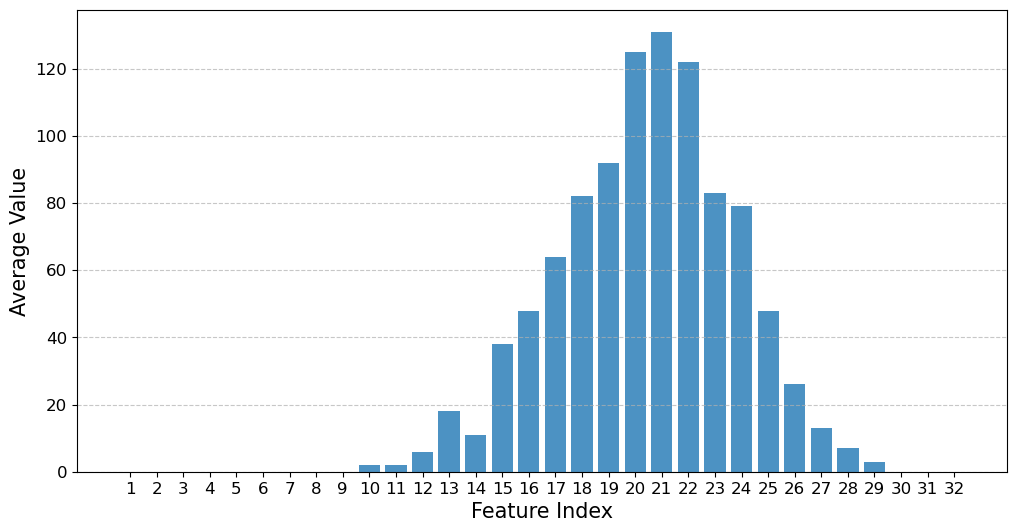

In [4]:
observed_data = galton_simulator(alpha=0.2, s=0.1)
unique_positions, counts = np.unique(observed_data, return_counts=True)

final_observed_data = np.zeros(32, dtype=int)

# Map the counts to their corresponding bins
for pos, count in zip(unique_positions, counts):
    final_observed_data[pos] = count

print(final_observed_data)

plt.figure(figsize=(12, 6))
plt.bar(range(1, 33), final_observed_data, alpha=0.8)
plt.xlabel('Feature Index')
plt.ylabel('Average Value')
plt.xticks(range(1, 33))  # Set x-ticks for each column index
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [5]:
def summary_statistics(data,arr_bin_index):
    mean_bin_index = np.sum(data * arr_bin_index)/np.sum(data)
    variance = np.sum(data * (arr_bin_index - mean_bin_index)**2)/np.sum(data)
    #skewness = skew(data)
    return np.array([mean_bin_index, variance])

def gauss_kernel(distance, h):
    return np.exp(-0.5 / (h*h) * distance**2) 

def abc_routine(experiment_data, num_samples, simulator, summary_func, num_rows, num_beads, h):
    """
    Approximate Bayesian Computation (ABC) routine.

    Args:
        experiment_data (np.ndarray): Observed data.
        num_samples (int): Number of prior samples.
        simulator (function): Simulator function.
        summary_func (function): Function to compute summary statistics.
        num_rows (int): Number of rows in the Galton board.
        num_beads (int): Number of beads to simulate.
        h (float): Bandwidth for the Gaussian kernel.

    Returns:
        np.ndarray: Accepted alpha parameters.
        float: Acceptance rate.
    """
    alpha_prior = np.random.uniform(0, 0.5, num_samples)
    s_prior = np.random.uniform(-0.25, 0.25, num_samples)
    accepted_params = []
    arr_bin_index = np.arange(1, 33, 1)
    accepted_count = 0

    for alpha, s in zip(alpha_prior, s_prior):
        i = np.random.randint(0, len(experiment_data))
        simulated_data = simulator(alpha, s, num_rows, num_beads)
        simulated_data = reshape_bin_array(simulated_data)
        
        # normalize the data
        simulated_data = simulated_data/np.sum(simulated_data)
        experiment_data[i] = experiment_data[i] / np.sum(experiment_data[i])

        simulated_stat = summary_func(simulated_data, arr_bin_index)
        observed_stat = summary_func(experiment_data[i], arr_bin_index)

        #print(simulated_stat)
        distance = np.linalg.norm(simulated_stat - observed_stat)
        kernel_prob = gauss_kernel(distance, h)
        
        #print(alpha, s, kernel_prob, simulated_stat, observed_stat)

        if kernel_prob > np.random.uniform(0, 1):
            accepted_params.append((alpha))
            accepted_count += 1

    return np.array(accepted_params), accepted_count/num_samples

experiment_data = np.load("board_data_.npy")

num_rows = 31
num_beads = 1000
num_samples = 40000
h = 1.8 # Bandwidth for the Gaussian kernel, about 5% acceptance rate

accepted_params, acceptance_rate = abc_routine(experiment_data, num_samples, galton_simulator, summary_statistics, num_rows,num_beads, h)
#print(accepted_params)
#print(acceptance_rate)
np.save('accepted_params.npy', accepted_params)



KeyboardInterrupt: 

In [ ]:
acceptance_probs = {}

h_values = [0.1, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
for h in h_values:
    accepted_params, acceptance_prob = abc_routine(experiment_data, num_samples, galton_simulator, summary_statistics, num_rows, num_beads, h)
    acceptance_probs[h] = acceptance_prob
    print(f"h = {h}, Acceptance Probability = {acceptance_prob}")


[0.41881473 0.23675094 0.40644418 ... 0.42466551 0.33352868 0.27638978]


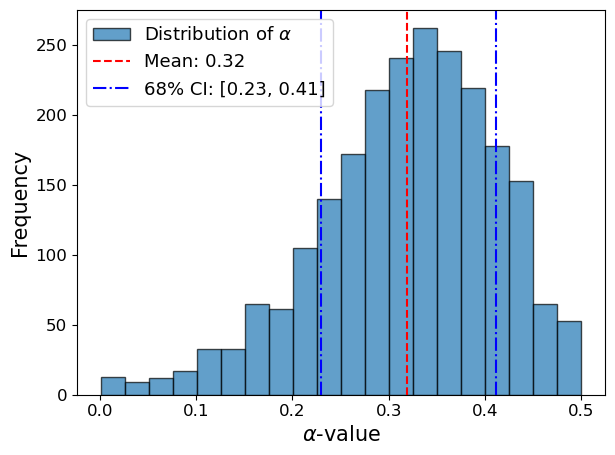

acceptance rate:  0.57375


In [122]:
accepted_params = np.load('accepted_params.npy')

mean_alpha = np.mean(accepted_params)
ci_lower, ci_upper = np.percentile(accepted_params, [16, 84])  # 68% CI corresponds to 16th and 84th percentiles


print(accepted_params)
# Need to redo
plt.hist(accepted_params, bins=20, edgecolor='black', alpha=0.7, label = r'Distribution of $\alpha$')
plt.axvline(mean_alpha, color='red', linestyle='--', label=f'Mean: {mean_alpha:.2f}')
plt.axvline(ci_lower, color='blue', linestyle='-.', label=f'68% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
plt.axvline(ci_upper, color='blue', linestyle='-.')

plt.xlabel(r'$\alpha$-value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('abc.pdf')
# Show plot
plt.show()

print("acceptance rate: ", len(accepted_params)/num_samples)


In [150]:
# Create simulation data for NN
num_samples = 100000
simulated_data = np.zeros((num_samples, 32), dtype=int)
alpha = np.random.uniform(0, 0.5, num_samples)
s = np.random.uniform(-0.25, 0.25, num_samples)

for i in range(num_samples):
    print(i)
    observed_data = galton_simulator(alpha[i], s[i], 31, 1000)
    final_observed_data = reshape_bin_array(observed_data)
    simulated_data[i] = final_observed_data
    

np.save("simulated_data1.npy", simulated_data)
np.save("simulated_params1.npy", np.vstack((alpha, s)).T)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Load the data
X = np.load("simulated_data.npy")
y = np.load("simulated_params.npy")

# Split data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the input features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Use the same scaler for the validation set

# Optionally, standardize the target variables (if necessary)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)


In [ ]:
# Define a simple neural network model using TensorFlow/Keras
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)  # Output layer for two target variables (alpha and s)
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=32, validation_data=(X_val_scaled, y_val_scaled))

# Make predictions
y_pred_scaled = model.predict(X_val_scaled)

# Inverse transform predictions
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Calculate the Mean Squared Error (MSE)
mse = mean_squared_error(y_val, y_pred)
print(f'Mean Squared Error (TensorFlow): {mse}')

In [9]:
#model.save('regression_model.h5')
# To load it:
model = tf.keras.models.load_model('regression_model.h5')

2024-12-19 22:26:41.984245: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-12-19 22:26:41.994089: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 22:26:42.002913: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


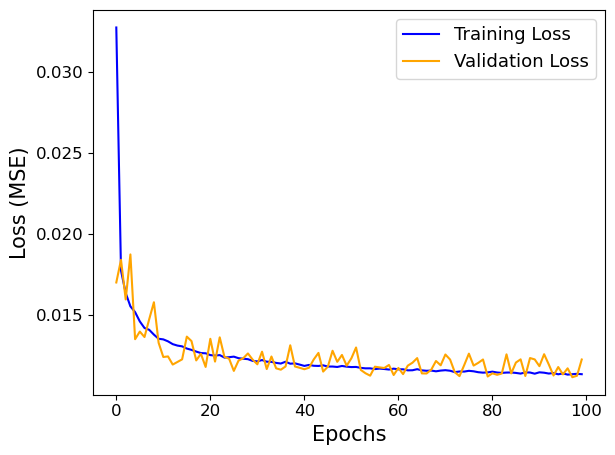

dict_keys(['loss', 'val_loss'])


In [107]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
#plt.title('Model Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('Loss (RMSE)')
plt.legend()
plt.tight_layout()
plt.savefig('NN_training.pdf')
plt.show()

print(history.history.keys())

2024-12-19 22:26:54.419331: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-12-19 22:26:54.442416: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2808000000 Hz


Alpha - MSE: 0.0005, MAE: 0.0174, RMSE: 0.0220 R2: 0.9768
S     - MSE: 0.0000, MAE: 0.0039, RMSE: 0.0051 R2: 0.9988


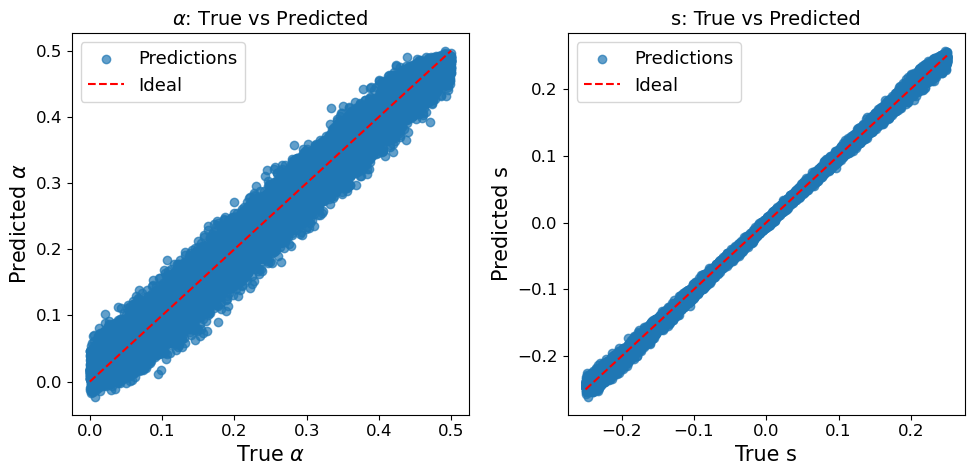

In [11]:
from sklearn.metrics import mean_absolute_error, r2_score

# Predictions on the validation set
y_pred_scaled = model.predict(X_val_scaled)

# Inverse transform predictions
y_pred = y_scaler.inverse_transform(y_pred_scaled)

# Separate true and predicted values for alpha and s
alpha_true, s_true = y_val[:, 0], y_val[:, 1]
alpha_pred, s_pred = y_pred[:, 0], y_pred[:, 1]

# Calculate errors for alpha
alpha_mse = mean_squared_error(alpha_true, alpha_pred)
alpha_mae = mean_absolute_error(alpha_true, alpha_pred)
alpha_r2 = r2_score(alpha_true, alpha_pred)

# Calculate errors for s
s_mse = mean_squared_error(s_true, s_pred)
s_mae = mean_absolute_error(s_true, s_pred)
s_r2 = r2_score(s_true, s_pred)

# RMSE
alpha_rmse = np.sqrt(alpha_mse)
s_rmse = np.sqrt(s_mse)

# Create error model for latent variable s
s_residuals = s_true - s_pred
s_residuals_mean = np.mean(s_residuals)
s_residuals_std = np.std(s_residuals)
s_residuals_gaussian = stats.norm(s_residuals_mean, s_residuals_std)

# Print error metrics
print(f"Alpha - MSE: {alpha_mse:.4f}, MAE: {alpha_mae:.4f}, RMSE: {alpha_rmse:.4f} R2: {alpha_r2:.4f}")
print(f"S     - MSE: {s_mse:.4f}, MAE: {s_mae:.4f}, RMSE: {s_rmse:.4f} R2: {s_r2:.4f}")

plt.figure(figsize=(10, 5))

# Alpha
plt.subplot(1, 2, 1)
plt.scatter(alpha_true, alpha_pred, alpha=0.7, label='Predictions')
plt.plot([min(alpha_true), max(alpha_true)], [min(alpha_true), max(alpha_true)], color='red', linestyle='--', label='Ideal')
plt.title(r'$\alpha$: True vs Predicted')
plt.xlabel(r'True $\alpha$')
plt.ylabel(r'Predicted $\alpha$')
plt.legend()

# S
plt.subplot(1, 2, 2)
plt.scatter(s_true, s_pred, alpha=0.7, label='Predictions')
plt.plot([min(s_true), max(s_true)], [min(s_true), max(s_true)], color='red', linestyle='--', label='Ideal')
plt.title('s: True vs Predicted')
plt.xlabel('True s')
plt.ylabel('Predicted s')
plt.legend()

plt.tight_layout()
plt.savefig('NN_true_pred.pdf')
plt.show()


In [12]:
# ABC routine with neural network

def NN_predictor(data, model):
    # Preprocess the input distribution
    input_scaled = scaler.transform(data.reshape(1, -1))
    predicted_scaled_params = model.predict(input_scaled)
    predicted_params = y_scaler.inverse_transform(predicted_scaled_params)
    return predicted_params


def abc_routine_nn(experiment_data, num_samples,model,error_values):
    """
    Approximate Bayesian Computation (ABC) routine with Neural network.

    Args:
        experiment_data (np.ndarray): Observed data.
        num_samples (int): Number of samples.
        model (tf.keras.Model): Neural network model.
        error_values (np.ndarray): Error values for the latent variable s.
    Returns:
        np.ndarray: Accepted alpha parameters.
    """
    alphas = np.random.uniform(0, 0.5, num_samples)
    h = 0.5
    accepted_params = []
    arr_bin_index = np.arange(1, 33, 1)

    # Error model RMSE?

    for alpha in alphas:
        i = np.random.randint(0, len(experiment_data))
        y_obs = experiment_data[i]
        
        # Predict the parameters using the neural network
        predicted_params = NN_predictor(y_obs, model)
        s_pred = predicted_params[0][1]

        s_pred += error_values[i]
        #print(error_model)
        
        simulation = galton_simulator(alpha, s_pred)
        simulation = reshape_bin_array(simulation)

        # normalize the data
        simulation = simulation/np.sum(simulation)
        y_obs= y_obs / np.sum(y_obs)

        summary_sim = summary_statistics(simulation,arr_bin_index)
        summary_exp = summary_statistics(y_obs,arr_bin_index)

        g = np.linalg.norm(summary_sim - summary_exp)
        kernel_prob = gauss_kernel(g, h) 

        p_accept = kernel_prob 
        print(alpha,p_accept)

        if p_accept > np.random.uniform(0, 1):
            accepted_params.append((alpha))
            #print("Accepted")

    return np.array(accepted_params)

model = tf.keras.models.load_model('regression_model.h5')
experiment_data = np.load("board_data_.npy")
error_values = s_residuals_gaussian.rvs(len(experiment_data))
num_samples = 20000
accepted_params_nn1 = abc_routine_nn(experiment_data, num_samples, model, error_values)

print(accepted_params_nn1/num_samples)

0.00572588009659758 6.23373066649441e-17
0.39361998761121075 0.1294604245974901
0.23844676028447626 0.00018983932776612313
0.10263753428593436 6.076781011916983e-09
0.12052038600254333 2.4939444378718784e-10
0.08510169440568816 1.6937695557812067e-42
0.46793872678178866 0.0076115694715655855
0.01771502722114804 1.67848429564377e-29
0.17725766620929784 9.577353611731537e-14
0.20933637682452377 7.122908077524913e-10
0.44331796625427644 0.0009192698546951811
0.22434856855502489 0.010669188319442852
0.4334925438512411 7.556874417878157e-06
0.18581488709955923 1.996179769693965e-13
0.2671279678368337 1.9469481666672638e-05
0.05897116514373085 7.846086466812376e-62
0.3151392172639101 0.972411966935792
0.2401095759136796 1.9580848901119787e-10
0.4745157044923418 1.7721924775118577e-16
0.19664589599092708 8.858742448577137e-14
0.09759333611608423 1.5749574480344188e-35
0.09061016673316524 4.0586738488906126e-33
0.0877744883744842 6.798807632744045e-20
0.1156260353030929 2.5018142613213643e-11


[0.31513922 0.4089251  0.37720512 ... 0.3636591  0.35273766 0.36812648]


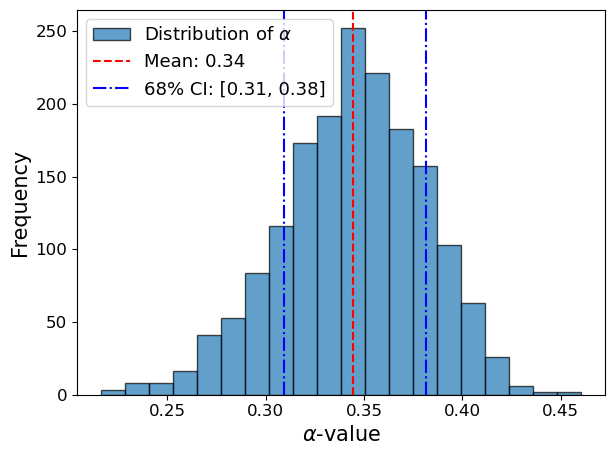

acceptance rate:  0.08545


In [13]:
# Plot the histogram of accepted parameters for ABC with NN
#np.save("accepted_params_nn.npy", accepted_params_nn)

print(accepted_params_nn1)

mean_alpha = np.mean(accepted_params_nn1)
ci_lower, ci_upper = np.percentile(accepted_params_nn1, [16, 84])  # 68% CI corresponds to 16th and 84th percentiles

plt.hist(accepted_params_nn1, bins=20, edgecolor='black', alpha=0.7, label = r'Distribution of $\alpha$')
plt.axvline(mean_alpha, color='red', linestyle='--', label=f'Mean: {mean_alpha:.2f}')
plt.axvline(ci_lower, color='blue', linestyle='-.', label=f'68% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
plt.axvline(ci_upper, color='blue', linestyle='-.')

plt.xlabel(r'$\alpha$-value')
plt.ylabel('Frequency')

plt.legend()
plt.tight_layout()
plt.savefig('abc_nn.pdf')
# Show plot
plt.show()

print("acceptance rate: ", len(accepted_params_nn1)/num_samples)

In [14]:
# ABC routine with neural network


def get_prior_samples(params):
    mean = np.mean(params)
    std = np.std(params)
    return np.random.normal(mean, std, len(params))

def seq_abc_routine_nn(experiment_data,error_values,model,accepted_params_nn):
    """
    Approximate Bayesian Computation (ABC) routine with Neural network.

    Args:
        experiment_data (np.ndarray): Observed data.
        error_values (np.ndarray): Error values for the latent variable s.
        model (tf.keras.Model): Neural network model.
        accepted_params_nn (np.ndarray): Accepted parameters from the previous ABC run.
    Returns:
        np.ndarray: Accepted (alpha) parameters.
    """
    alphas = get_prior_samples(accepted_params_nn)
    h = 0.6
    accepted_params = []
    arr_bin_index = np.arange(1, 33, 1)

    for alpha in alphas:
        i = np.random.randint(0, len(accepted_params_nn))
        y_obs = experiment_data[i]
        
        # Predict the parameters using the neural network
        predicted_params = NN_predictor(y_obs, model)
        s_pred = predicted_params[0][1]
        
        s_pred += error_values[i]

        simulation = galton_simulator(alpha, s_pred)
        simulation = reshape_bin_array(simulation)

        simulation = simulation/np.sum(simulation)
        y_obs= y_obs / np.sum(y_obs)

        summary_sim = summary_statistics(simulation,arr_bin_index)
        summary_exp = summary_statistics(y_obs,arr_bin_index)

        g = np.linalg.norm(summary_sim - summary_exp)
        kernel_prob = gauss_kernel(g, h)

        p_accept = kernel_prob
        print(alpha,p_accept)

        if p_accept > np.random.uniform(0, 1):
            accepted_params.append((alpha))
            #print("Accepted")

    return np.array(accepted_params)

model = tf.keras.models.load_model('regression_model.h5')
experiment_data = np.load("board_data_.npy")
#num_samples = 4000
error_values = s_residuals_gaussian.rvs(len(accepted_params_nn1))
seq_accepted_params_nn = seq_abc_routine_nn(experiment_data, error_values, model, accepted_params_nn1)

0.3616716595460168 0.33723061149457606
0.36960664710157054 0.7975105322617808
0.3190868120510239 0.10114899792318541
0.3220092765372633 0.9614223081251285
0.3245306257599685 0.42420136104618655
0.3306695847701277 4.621258184887906e-06
0.37577561354692773 0.06410106761352925
0.4333364184780243 0.0002815399042101054
0.3403184792550216 0.6969791599094916
0.3914204705211945 0.3211645045429187
0.3193959817401717 0.07253609794327441
0.38755739867590466 0.8745598560845487
0.38354655868705323 0.7008975432939459
0.38153434510782713 0.9431351902000351
0.3216397989252164 0.9226171160405545
0.29342336241112793 0.0559266715589385
0.29995003922888713 0.6159889555090475
0.32619351247738526 0.5163703383359624
0.35726554368762453 0.8099681310895025
0.32238476454114456 0.8821956661334674
0.3036696763963734 0.023314863679397835
0.3231905550099204 0.690186014676731
0.3716903077513335 0.0019721735272482045
0.34375172620346 0.2762944035287988
0.3209323445564434 0.45494802798886963
0.3456458215406324 0.71720

[0.36960665 0.32200928 0.32453063 0.3875574  0.38354656 0.38153435
 0.3216398  0.32619351 0.32238476 0.32319056 0.32093234 0.34564582
 0.34844037 0.34454913 0.29876991 0.30877137 0.33449909 0.29322946
 0.34766569 0.36703776 0.3427012  0.34095773 0.3196544  0.37324237
 0.31265519 0.33736983 0.3172152  0.37138345 0.34293423 0.34022802
 0.34407713 0.37910122 0.39403927 0.37506282 0.33231069 0.32537675
 0.32883713 0.34955321 0.33045647 0.32630403 0.36481364 0.29443741
 0.34108393 0.35979997 0.33614536 0.40505722 0.37162874 0.36986284
 0.36151328 0.36504422 0.38509253 0.34731524 0.29317709 0.35919647
 0.33304468 0.35304553 0.34804936 0.35267081 0.29598144 0.36701034
 0.29943523 0.36537528 0.34263388 0.3528066  0.37476363 0.35267803
 0.33332612 0.35342241 0.3440579  0.31669535 0.36757091 0.32423617
 0.33179536 0.39389674 0.36570595 0.325601   0.3424355  0.34506606
 0.29733482 0.35775084 0.34473175 0.38758024 0.29608923 0.37802387
 0.27204517 0.35489189 0.32217443 0.36707688 0.36088389 0.3224

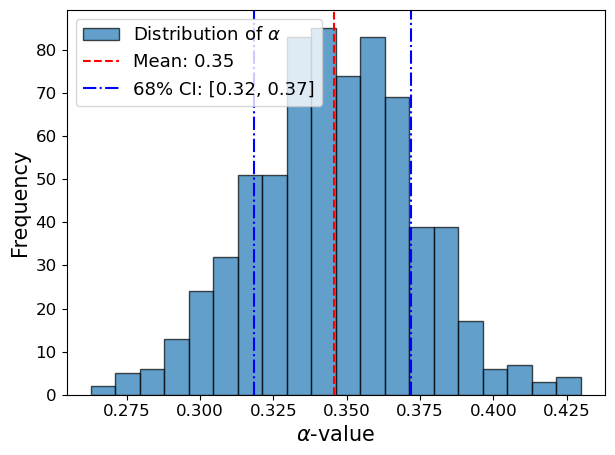

acceptance rate:  0.03465


In [15]:
# Plot the histogram of accepted parameters for ABC with NN
#np.save('seq_accepted_params_nn.npy', seq_accepted_params_nn)
print(seq_accepted_params_nn)

mean_alpha = np.mean(seq_accepted_params_nn)
ci_lower, ci_upper = np.percentile(seq_accepted_params_nn, [16, 84])  # 68% CI corresponds to 16th and 84th percentiles

plt.hist(seq_accepted_params_nn, bins=20, edgecolor='black', alpha=0.7, label = r'Distribution of $\alpha$')
plt.axvline(mean_alpha, color='red', linestyle='--', label=f'Mean: {mean_alpha:.2f}')
plt.axvline(ci_lower, color='blue', linestyle='-.', label=f'68% CI: [{ci_lower:.2f}, {ci_upper:.2f}]')
plt.axvline(ci_upper, color='blue', linestyle='-.')
plt.xlabel(r'$\alpha$-value')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.savefig('seq_abc_nn.pdf')
plt.show()

print("acceptance rate: ", len(seq_accepted_params_nn)/num_samples)


In [84]:
x = np.linspace(-1, 1, 1000)
print(s_residuals_gaussian.pdf(x))

[0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 0.000000